In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import sys
sys.path.append('/home/seguin/Replica-search/')

In [3]:
import tensorflow as tf
from replica_learn.models.xception import xception_fn

In [23]:
my_graph = tf.Graph()
with my_graph.as_default():
    to_be_assigned = tf.placeholder(tf.float32)
    _in = tf.placeholder(tf.float32, [32, 299, 299, 3])
    my_xception = xception_fn(_in, blocks=15)

In [5]:
sess = tf.InteractiveSession(graph=my_graph)

In [6]:
import tensorflow.contrib.keras
keras = tensorflow.contrib.keras
tf.reset_default_graph()
sess_k = tf.InteractiveSession()
keras_network_full = keras.applications.Xception(include_top=False)

In [7]:
keras_network = keras_network_full#keras.models.Model(keras_network_full.input, keras_network_full.get_layer('add_3').output)

In [8]:
from collections import defaultdict

def separate_keras_layers(graph):
    batchnorm_layers, conv_layers, sepconv_layers = [], [], []
    variable_dict = defaultdict(list)

    for v in graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
        layer_name = v.name.split('/')[0]
        if 'sepconv' in layer_name and 'bn' not in layer_name:
            if layer_name not in sepconv_layers:
                sepconv_layers.append(layer_name)
        elif 'conv' in layer_name and 'bn' not in layer_name:
            if layer_name not in conv_layers:
                conv_layers.append(layer_name)
        elif 'bn' in layer_name or 'batch_normalization' in layer_name:
            if layer_name not in batchnorm_layers:
                batchnorm_layers.append(layer_name)
        else:
            raise Error(layer_name)
        variable_dict[layer_name].append(v)
    return batchnorm_layers, conv_layers, sepconv_layers, variable_dict
        
def separate_tf_layers(graph):
    batchnorm_layers, conv_layers, sepconv_layers = [], [], []

    for v in graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
        layer_name = '/'.join(v.name.split('/')[:-1])
        if 'BatchNorm' in layer_name:
            if layer_name not in batchnorm_layers:
                batchnorm_layers.append(layer_name)
        elif 'SeparableConv' in layer_name:
            if layer_name not in sepconv_layers:
                sepconv_layers.append(layer_name)
        elif 'Conv' in layer_name:
            if layer_name not in conv_layers:
                conv_layers.append(layer_name)
        else:
            raise Exception(layer_name)
    return batchnorm_layers, conv_layers, sepconv_layers

In [9]:
k_batchnorm_layers, k_conv_layers, k_sepconv_layers, variable_dict = separate_keras_layers(tf.get_default_graph())
batchnorm_layers, conv_layers, sepconv_layers = separate_tf_layers(my_graph)

In [10]:
graph_variables = {v.name: v for v in my_graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)}

for k_layer_name, layer_name in list(zip(k_batchnorm_layers, batchnorm_layers))+list(zip(k_conv_layers, conv_layers)) +list(zip(k_sepconv_layers,sepconv_layers)):
    for v in variable_dict[k_layer_name]:
        param_name = v.name.split('/')[-1]
        param_name = param_name.replace('kernel', 'weights')
        output_var = graph_variables['{}/{}'.format(layer_name, param_name)]
        print(v.name, output_var.name)
        sess.run(output_var.assign(sess_k.run(v)))

block1_conv1_bn/gamma:0 Xception/block1/Conv_1/BatchNorm/gamma:0
block1_conv1_bn/beta:0 Xception/block1/Conv_1/BatchNorm/beta:0
block1_conv1_bn/moving_mean:0 Xception/block1/Conv_1/BatchNorm/moving_mean:0
block1_conv1_bn/moving_variance:0 Xception/block1/Conv_1/BatchNorm/moving_variance:0
block1_conv2_bn/gamma:0 Xception/block1/Conv_2/BatchNorm/gamma:0
block1_conv2_bn/beta:0 Xception/block1/Conv_2/BatchNorm/beta:0
block1_conv2_bn/moving_mean:0 Xception/block1/Conv_2/BatchNorm/moving_mean:0
block1_conv2_bn/moving_variance:0 Xception/block1/Conv_2/BatchNorm/moving_variance:0
batch_normalization_1/gamma:0 Xception/block2/Conv/BatchNorm/gamma:0
batch_normalization_1/beta:0 Xception/block2/Conv/BatchNorm/beta:0
batch_normalization_1/moving_mean:0 Xception/block2/Conv/BatchNorm/moving_mean:0
batch_normalization_1/moving_variance:0 Xception/block2/Conv/BatchNorm/moving_variance:0
block2_sepconv1_bn/gamma:0 Xception/block2/SeparableConv_1/BatchNorm/gamma:0
block2_sepconv1_bn/beta:0 Xception/bl

In [11]:
#from tensorflow.contrib.keras.preprocessing import image
img = tensorflow.contrib.keras.preprocessing.image.load_img('cat.jpg', target_size=(299, 299))
img = tensorflow.contrib.keras.preprocessing.image.img_to_array(img)
preprocessed = tensorflow.contrib.keras.applications.xception.preprocess_input(img[None].copy())

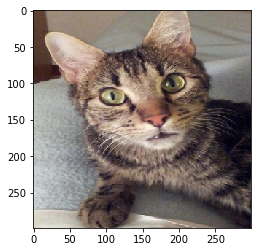

In [12]:
plt.imshow(img/255)

In [13]:
preds_keras = keras_network.predict(preprocessed)

In [14]:
my_preds = sess.run(my_xception, {_in: img[None]})

In [15]:
np.allclose(preds_keras, my_preds)

True

In [16]:
saver = tf.train.Saver(var_list=my_graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

In [17]:
saver.save(sess, '/home/seguin/xception.ckpt', write_meta_graph=False, write_state=False)

'/home/seguin/xception.ckpt'